## Links Importantes

- Apresentação: https://docs.google.com/presentation/d/1PUw67k7vlwV0noWvi_aXtpGH4s6DVn1o11MKA89gzbg/edit
- Repositório: https://github.com/ArthurMesquita96/Case-O-Boticario
- Projeto Big Query: https://console.cloud.google.com/bigquery?inv=1&invt=Ab4gkg&project=case-o-boticario-467017
- Dashboard: https://lookerstudio.google.com/reporting/da0b9fe3-e710-4132-912d-d65ad5be7ab8/page/XdRTF

## Instruções para Uso

Antes de rodar o script, lembre-se de:

1. Criar um ambiente virtual

- `python -m venv ambiente_virtual`

2. Ativar o ambiente virtual

- `source ambiente_virtual/bin/activate`

3. Instalar as bibliotecas:

- `pip install -r requirements.txt`

## Import

In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import joblib
from google.cloud import bigquery

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn.model_selection as ms
import sklearn.metrics as mt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

## Variáveis

In [2]:
PROJETO = 'case-o-boticario-467017' ## projeto_bq
TARGET = 'risco'                    ## nome variável resposta
sns.set_palette('dark')             ## Definindo paleta de cores

## Funções

In [3]:
## Auxiliares

def save_picked_file(file, name):
    """
    Salva um objeto Python em formato `.pkl` usando compressão.

    Args:
        file (object): Objeto a ser serializado.
        name (str): Caminho e nome base do arquivo (sem extensão).

    Returns:
        list[str]: Lista com o caminho do arquivo salvo.
    """
    return joblib.dump(file, f'{name}.pkl', compress=3)


def load_picked_file(name):
    """
    Carrega um objeto Python de um arquivo `.pkl`.

    Args:
        name (str): Caminho e nome base do arquivo (sem extensão).

    Returns:
        object: Objeto desserializado do arquivo.
    """
    return joblib.load(f'{name}.pkl')


def save_parquet_file(file, name):
    """
    Salva um DataFrame em formato `.parquet`.

    Args:
        file (pandas.DataFrame): DataFrame a ser salvo.
        name (str): Caminho e nome base do arquivo (sem extensão).

    Returns:
        None
    """
    table = pa.Table.from_pandas(file)
    return pq.write_table(table, f'{name}.parquet')


def load_parquet_file(name):
    """
    Carrega um arquivo `.parquet` e o converte em um DataFrame.

    Args:
        name (str): Caminho e nome base do arquivo (sem extensão).

    Returns:
        pandas.DataFrame: Tabela carregada do arquivo.
    """
    table = pq.read_table(f'{name}.parquet')
    return table.to_pandas()


def load_data_bigquery(projeto, query):
    """
    Executa uma query no BigQuery e retorna os dados como um DataFrame.

    Args:
        projeto (str): Nome do projeto no GCP.
        query (str): Comando SQL a ser executado.

    Returns:
        pandas.DataFrame: Dados retornados pela consulta.
    """
    client = bigquery.Client(project=projeto)
    query_job = client.query(query)

    df_list = []
    for row in query_job.result():
        df_list.append(dict(row))

    return pd.DataFrame(df_list)


def create_table_bigquery(projeto, dataset, table_name, data):
    """
    Cria ou sobrescreve uma tabela no BigQuery com os dados de um DataFrame.

    Args:
        projeto (str): Nome do projeto no GCP.
        dataset (str): Nome do dataset no BigQuery.
        table_name (str): Nome da tabela a ser criada.
        data (pandas.DataFrame): Dados a serem carregados.

    Returns:
        str: Confirmação da conclusão do job.
    """
    client = bigquery.Client(project=projeto)
    table_ref = client.dataset(dataset).table(table_name)
    job = client.load_table_from_dataframe(data, table_ref)
    job.result()
    
    return "Done!"


def salvar_grafico(nome_arquivo, pasta_destino, figura=None, formato='png', dpi=300):
    """
    Salva a figura atual do Matplotlib em um diretório especificado.

    Args:
        nome_arquivo (str): Nome do arquivo (sem extensão).
        pasta_destino (str): Caminho para salvar o gráfico.
        figura (matplotlib.figure.Figure, optional): Figura a ser salva. Se None, usa a figura atual.
        formato (str, optional): Formato do arquivo (ex: 'png', 'jpg').
        dpi (int, optional): Resolução da imagem.

    Returns:
        str: Caminho completo do arquivo salvo.
    """
    if figura is None:
        figura = plt.gcf()
    
    if not os.path.exists(pasta_destino):
        os.makedirs(pasta_destino)
    
    caminho_completo = os.path.join(pasta_destino, f"{nome_arquivo}.{formato}")
    figura.savefig(caminho_completo, format=formato, dpi=dpi, bbox_inches='tight')
    print(f"Gráfico salvo em: {caminho_completo}")

    return None


def padronizar_coluna_data(df, coluna):
    """
    Padroniza os valores de uma coluna de data para o formato 'YYYY-MM-DD'.

    Suporta formatos como 'YYYY-WW' (semana do ano) e 'YYYY-MM-DD'.

    Args:
        df (pandas.DataFrame): DataFrame de entrada.
        coluna (str): Nome da coluna contendo datas.

    Returns:
        pandas.DataFrame: DataFrame com a coluna convertida para datetime.
    """

    def parse_data(valor):
        if isinstance(valor, str) and '-' in valor:
            partes = valor.split('-')
            if len(partes) == 2 and partes[1].isdigit() and len(partes[1]) == 2:
                ano = int(partes[0])
                semana = int(partes[1])
                return pd.to_datetime(f'{ano}-W{semana}-1', format='%Y-W%W-%w')
            else:
                try:
                    return pd.to_datetime(valor)
                except:
                    return pd.NaT
        return pd.NaT

    df[coluna] = df[coluna].apply(parse_data)
    df[coluna] = df[coluna].dt.strftime('%Y-%m-%d')
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    return df


def statistics(data):
    """
    Calcula estatísticas descritivas para variáveis numéricas de um DataFrame.

    Inclui medidas de tendência central, dispersão, forma e presença de nulos.

    Args:
        data (pandas.DataFrame): DataFrame com colunas numéricas.

    Returns:
        pandas.DataFrame: Tabela com estatísticas para cada variável numérica.
    """
    num_data = data.select_dtypes(include=['int', 'float'])

    mean = num_data.apply(np.mean)
    q50 = num_data.quantile(0.5)
    q25 = num_data.quantile(0.25)
    q75 = num_data.quantile(0.75)
    range_ = num_data.apply(lambda x: x.max() - x.min())
    count = num_data.count()

    min_ = num_data.apply(min)
    max_ = num_data.apply(max)
    std = num_data.apply(np.std)
    skew = num_data.apply(lambda x: x.skew())
    kurtosis = num_data.apply(lambda x: x.kurtosis())

    metrics = pd.DataFrame({
        'count': count,
        'null_values': num_data.shape[0] - count,
        'type': num_data.dtypes,
        'range': range_,
        'min': min_,
        'quant25': q25,
        'median': q50,
        'quant75': q75,
        'max': max_,
        'mean': mean,
        'std': std,
        'skew': skew,
        'kurtosis': kurtosis
    })

    return np.round(metrics, 1)


## Plots

def plot_matrix(data, columns_features, n_rows, n_cols, plot, sort_by= None, plot_kwargs = {}, loop_feature = None, figure = None, figsize = (15,15), label = True, save_image = False, nome_imagem='imagem', formato='png', dpi=700, pasta_destino='images/'):

    """
    Cria uma matriz de gráficos para comparar visualmente múltiplas variáveis.

    Args:
        data (pd.DataFrame): Conjunto de dados de entrada.
        columns_features (list): Lista de colunas a serem plotadas.
        n_rows (int): Número de linhas da grade de plots.
        n_cols (int): Número de colunas da grade de plots.
        plot (callable): Função de plotagem (ex: sns.barplot, sns.lineplot).
        sort_by (str, optional): Coluna usada para ordenar os dados.
        plot_kwargs (dict, optional): Argumentos adicionais passados para a função de plot.
        loop_feature (str, optional): Parâmetro da função de plotagem que será atualizado com o nome da feature.
        figure (matplotlib.figure.Figure, optional): Figura existente para reutilização.
        figsize (tuple, optional): Tamanho da figura (largura, altura).
        label (bool, optional): Se True, adiciona rótulos aos gráficos.
        save_image (bool, optional): Se True, salva o gráfico gerado como imagem.
        nome_imagem (str, optional): Nome do arquivo de imagem a ser salvo.
        formato (str, optional): Formato do arquivo (ex: 'png').
        dpi (int, optional): Resolução da imagem salva.
        pasta_destino (str, optional): Caminho para salvar o gráfico.

    Returns:
        None
    """

    grid = gridspec.GridSpec(n_rows, n_cols)

    if figure:
        figure
    else:
        plt.figure(figsize=figsize)

    for r in range(0, n_rows):
        for c in range(0, n_cols ):
            if (c + r*n_cols) >= len(columns_features):
                break
            else:
                feature = columns_features[ (c + r*n_cols) ]

                if sort_by:
                    data = data.sort_values(f'{sort_by}',ascending = False)
                else:
                    data = data.sort_values(f'{feature}',ascending = False)

                if loop_feature:
                    plot_kwargs[loop_feature] = feature
                    
                plt.subplot(grid[r, c])
                plt.title(f'{feature}')
                g = plot(data = data, **plot_kwargs)

                plt.xticks(rotation = 30)

                if label:
                    if plot.__name__ == 'lineplot':
                        if loop_feature == 'y':
                            y_col = feature
                            x_col = plot_kwargs['x']
                        else:
                            y_col = plot_kwargs['y']
                            x_col = feature

                        for i, row in data.iterrows():
                            g.annotate(str(np.round(row[y_col], 1)), (row[x_col], row[y_col]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)
                    else:
                        for i in g.containers:
                            g.bar_label(i, color = 'black',label_type='edge')
                else:
                    pass

    plt.tight_layout()

    if save_image:
        salvar_grafico(nome_imagem, pasta_destino, figura=plt.gcf(), formato=formato, dpi=dpi)

def analise_multivariada(df, atributos_numericos, nome_arquivo='analise_multivariada', metodo='pearson', dpi=700):
    """
    Gera um mapa de calor de correlação entre variáveis numéricas e salva a imagem.

    Args:
        df (pd.DataFrame): Conjunto de dados de entrada.
        atributos_numericos (list): Lista de colunas numéricas a serem avaliadas.
        nome_arquivo (str, optional): Nome do arquivo da imagem gerada.
        metodo (str, optional): Método de correlação ('pearson', 'kendall', 'spearman').
        dpi (int, optional): Resolução da imagem.

    Returns:
        None
    """
    # Selecionar colunas numéricas + risco
    colunas = atributos_numericos
    num_attributes = df[colunas]

    # Calcular correlação
    correlations = num_attributes.corr(method=metodo)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.title('Mapa de Correlações', fontsize=15)
    sns.heatmap(correlations, annot=True, fmt='.2f')

    # Salvar figura
    salvar_grafico(nome_arquivo, '../images/', figura=plt.gcf(), formato='png', dpi=dpi)

## Data Preparation

def split_dataset(data, test_size, target):
    """
    Divide o dataset em conjuntos de treino e teste, mantendo X e y alinhados.

    Args:
        data (pd.DataFrame): DataFrame original com as features e o target.
        test_size (float): Proporção do conjunto de teste.
        target (str): Nome da coluna alvo.

    Returns:
        tuple: Dois DataFrames, um com os dados de treino e outro com os dados de teste,
               contendo ambos features e target lado a lado.
    """
    dados = data.copy()

    A1, B1, A2, B2 = ms.train_test_split(dados.drop(target, axis=1), dados[target], test_size=test_size, random_state=0)
    
    A = pd.concat([A1,A2], axis=1)
    B = pd.concat([B1,B2], axis=1)

    return A, B

def target_encoding(df, column, train = True, final=False) :
    """
    Aplica codificação target encoding em uma variável categórica com base na média da variável 'risco'.

    Args:
        df (pd.DataFrame): Conjunto de dados original.
        column (str): Nome da coluna categórica a ser codificada.
        train (bool): Define se está em modo de treinamento ou aplicação do encoding.
        final (bool): Define se o encoder deve ser salvo como definitivo (True) ou temporário (False).

    Returns:
        pd.DataFrame: DataFrame com a coluna codificada via target encoding.
    """
    data = df.copy()

    if train:
        media_por_categoria = data[[column,'risco']].groupby(column).agg(total=('risco','mean')).reset_index()
        media_por_categoria['total'] = round(media_por_categoria['total'],2)
        media_por_categoria = media_por_categoria.set_index(column)['total'].to_dict()

        data[column] = data[column].map(media_por_categoria)

        if final:
            save_picked_file(media_por_categoria, f'../params/preparation/target_encoding_{column}')
        else:
            save_picked_file(media_por_categoria, f'../params/preparation/tmp/target_encoding_{column}')

    else:
        
        if final:
            media_por_categoria = load_picked_file(f'../params/preparation/target_encoding_{column}')
        else:
            media_por_categoria = load_picked_file(f'../params/preparation/tmp/target_encoding_{column}')

        data[column] = data[column].map(media_por_categoria)
        data.loc[data[column].isna(), column] = data[column].mean()

    return data

def frequency_encoding(df, column, train=True, final=False):
    """
    Aplica codificação por frequência em uma coluna categórica.

    A codificação por frequência substitui cada categoria pelo valor proporcional de sua ocorrência no dataset.
    Durante o treinamento, as frequências são calculadas e salvas para uso posterior. Em fase de inferência, 
    as categorias desconhecidas são substituídas pela média das frequências.

    Args:
        df (pd.DataFrame): Conjunto de dados contendo a coluna a ser codificada.
        column (str): Nome da coluna categórica.
        train (bool): Indica se a função está sendo executada em modo de treinamento.
        final (bool): Define se os parâmetros devem ser salvos como definitivos ou temporários.

    Returns:
        pd.DataFrame: DataFrame com a coluna transformada via frequency encoding.
    """

    data = df.copy()

    if train:
        # Calcula a frequência relativa da categoria
        freq_map = data[column].value_counts(normalize=True).round(4).to_dict()
        
        # Aplica o encoding
        data[column] = data[column].map(freq_map)

        # Salva o dicionário para uso posterior
        if final:
            save_picked_file(freq_map, f'../params/preparation/freq_encoding_{column}')
        else:
            save_picked_file(freq_map, f'../params/preparation/tmp/freq_encoding_{column}')

    else:

        # Carrega o dicionário salvo
        if final:
            freq_map = load_picked_file(f'../params/preparation/freq_encoding_{column}')
        else:
            freq_map = load_picked_file(f'../params/preparation/tmp/freq_encoding_{column}')
        
        # Aplica o encoding
        data[column] = data[column].map(freq_map)

        # Trata categorias novas com a média das frequências conhecidas
        data.loc[data[column].isna(), column] = np.mean(list(freq_map.values()))

    return data


def cyclical_encoding(df, column, final = False):
    """
    Aplica codificação cíclica a colunas com dados periódicos (como mês ou ano).

    Transforma a variável em duas novas colunas usando funções seno e cosseno para preservar a natureza circular dos dados.

    Args:
        df (pd.DataFrame): Conjunto de dados original.
        column (str): Nome da coluna periódica (ex: 'mes_ciclo_previsto' ou 'ano_ciclo_previsto').
        final (bool): Parâmetro reservado para consistência com outras funções (não utilizado nesta).

    Returns:
        pd.DataFrame: DataFrame com duas novas colunas adicionadas: {coluna}_sin e {coluna}_cos.
    """

    data = df.copy()

    match column:
        case 'ano_ciclo_previsto':
            max_value = df[column].max()
        case 'mes_ciclo_previsto':
            max_value = 12     

    data[f'{column}_sin'] = data[f'{column}'].apply(lambda x: np.sin(x*(2*np.pi/max_value)))
    data[f'{column}_cos'] = data[f'{column}'].apply(lambda x: np.cos(x*(2*np.pi/max_value)))

    return data

def preparacao_dos_dados(df, dict_preparation, is_train=True, final = False):
    """
    Aplica múltiplos tipos de codificação em colunas de um DataFrame de acordo com um dicionário de preparação.

    Esta função é responsável por iterar sobre o dicionário de preparação fornecido, onde cada chave é uma
    coluna e o valor associado é o tipo de codificação desejada (target, frequency ou cyclical).

    Args:
        df (pd.DataFrame): DataFrame original com as colunas a serem transformadas.
        dict_preparation (dict): Dicionário com os nomes das colunas e os tipos de codificação a aplicar.
        is_train (bool): Define se o processo está em modo de treinamento ou aplicação.
        final (bool): Define se os parâmetros devem ser salvos/carregados como definitivos ou temporários.

    Returns:
        pd.DataFrame: DataFrame com todas as transformações aplicadas conforme especificado.
    """
    data = df.copy()

    for column, preparation in dict_preparation.items():
        try:
            match preparation:
                case 'target_encoding':
                    data = target_encoding(data, column, train=is_train, final=final)
                case 'frequency_encoding':
                    data = frequency_encoding(data, column, train=is_train, final=final)
                case 'cyclical_encoding':
                    data = cyclical_encoding(data, column, final=final)  
        except:
            pass

    return data      

## Machine Learning

def calcular_importancia_variaveis(model, dados, dict_preparation, columns_to_drop, target_col):
    """
    Calcula a importância das variáveis de um modelo após a preparação dos dados.

    Args:
        model (sklearn.BaseEstimator): Modelo de aprendizado de máquina que possui o atributo `feature_importances_`.
        dados (pd.DataFrame): DataFrame contendo os dados brutos.
        dict_preparation (dict): Dicionário com os tipos de codificação para cada coluna.
        columns_to_drop (list): Lista de colunas a serem removidas antes do treino.
        target_col (str): Nome da coluna alvo.

    Returns:
        pd.DataFrame: DataFrame com as features e suas respectivas importâncias ordenadas.
    """

    # Preparar dados
    dados_preparados = preparacao_dos_dados(dados, dict_preparation, is_train=True)

    X = dados_preparados.drop(columns=columns_to_drop, axis=1)
    y = dados_preparados[target_col]

    # Treinar modelo
    model.fit(X, y)

    # Calcular importância
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.asarray(X.columns.tolist())

    # Criar DataFrame
    features_importances = pd.DataFrame({
        'feature': feature_names[indices],
        'importance': np.round(importances[indices], 4)
    })

    return features_importances

def seleciona_features(features_importances, treadshot):
    """
    Seleciona variáveis com importância acima de um determinado limiar.

    Args:
        features_importances (pd.DataFrame): DataFrame com as colunas 'feature' e 'importance'.
        treadshot (float): Limiar mínimo de importância para que a feature seja selecionada.

    Returns:
        list: Lista de nomes das features selecionadas.
    """

    features_selected = features_importances.loc[features_importances['importance'] >= treadshot, 'feature'].tolist()

    return features_selected

def prepare_fit_and_predict(modelo, dados_treino, dados_teste, dict_preparation, features_selected, TARGET):
    """
    Prepara os dados, treina o modelo e realiza a predição.

    Args:
        modelo (sklearn.BaseEstimator): Modelo a ser treinado.
        dados_treino (pd.DataFrame): DataFrame com dados de treino.
        dados_teste (pd.DataFrame): DataFrame com dados de teste.
        dict_preparation (dict): Dicionário com os tipos de codificação para cada coluna.
        features_selected (list): Lista de features selecionadas para o treino.
        TARGET (str): Nome da coluna alvo.

    Returns:
        tuple: y_real (valores reais), y_hat (preditos), modelo treinado.
    """

    ## preparação dos dados de treino
    dados_treino_transformed = preparacao_dos_dados(dados_treino, dict_preparation, is_train=True)
    X_treino = dados_treino_transformed[features_selected].copy()
    y_treino = dados_treino_transformed[TARGET].copy()

    ## preparacao dos dados de teste
    dados_teste_transformed = preparacao_dos_dados(dados_teste, dict_preparation, is_train=False)
    X_teste = dados_teste_transformed[features_selected].copy()
    y_real = dados_teste_transformed[TARGET].copy()

    ## ajuste do modelo
    modelo.fit(X_treino, y_treino)

    ## predicao do modelo
    y_hat = modelo.predict(X_teste)

    return y_real, y_hat, modelo

def cross_validation(k_folds, modelo, nome_modelo, dados, dict_preparation, features_selected, TARGET):
    """
    Realiza validação cruzada com k-folds, calcula métricas médias e treina o modelo final em todos os dados.

    Args:
        k_folds (sklearn.model_selection.StratifiedKFold): Objeto k-fold configurado.
        modelo (sklearn.BaseEstimator): Modelo a ser validado.
        nome_modelo (str): Nome do modelo para fins de identificação.
        dados (pd.DataFrame): Dataset completo com features e target.
        dict_preparation (dict): Dicionário com os tipos de codificação a aplicar.
        features_selected (list): Lista de features a serem utilizadas no modelo.
        TARGET (str): Nome da coluna alvo.

    Returns:
        pd.DataFrame: DataFrame contendo as métricas médias da validação cruzada.
    """

    # armazena métricas dos modelos
    df_results = pd.DataFrame()

    ## armazena métricas dos modelos para cada fold
    metricas_folds = []

    ## para cada fold
    for fold, (train_idx, val_idx) in enumerate(k_folds.split(dados, dados[TARGET])):

        ## seleciona segmento de dados
        dados_treino = dados.iloc[train_idx]
        dados_validacao = dados.iloc[val_idx]
        
        ## preparação, ajuste e predição
        y_real, y_hat, _ = prepare_fit_and_predict(modelo, dados_treino, dados_validacao, dict_preparation, features_selected, TARGET)

        ## avalia modelos
        df_aux = classification_metrics(nome_modelo, y_real, y_hat)
        df_aux['fold'] = fold + 1

        ## armazena resultados
        metricas_folds.append(df_aux)

    # calcula média de cada fold
    df_modelo = pd.concat(metricas_folds, axis=0)
    df_modelo_mean = df_modelo.drop(columns=['fold']).groupby("Model Name").mean(numeric_only=True).reset_index()
    df_results = pd.concat([df_results, df_modelo_mean], axis=0)

    # treina o modelo final em todos os dados
    dados_transformed = preparacao_dos_dados(dados, dict_preparation, True)

    X_treino = dados_transformed[features_selected]
    y_treino = dados_transformed[TARGET]
    modelo.fit(X_treino, y_treino)
    
    ## salvando modelo
    save_picked_file(file=modelo, name=f'../models/tmp/modelo_{nome_modelo}_cv')

    return df_results

## Avalicação

def classification_metrics(model_name, y_true, y_pred):
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, zero_division=0)
    recall = mt.recall_score(y_true, y_pred)
    f1 = mt.f1_score(y_true, y_pred)

    return pd.DataFrame({
        'Model Name': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1]
    })

## Carregando Dados

In [ ]:
## Query que gerou a tabela final utilizada no case

'''
    CREATE OR REPLACE TABLE `dados.bd_niveis_de_risco_por_produto` AS

    WITH

    base_niveis_risco_por_produto AS (
    SELECT
        sku.cod_projeto,
        CAST(SPLIT(sku.des_nome_projeto, ' ')[1] AS INT64) AS des_nome_projeto,
        sku.des_validade_projeto,
        CAST(SPLIT(sku.des_marca, ' ')[1] AS INT64) AS des_marca,
        CAST(SPLIT(sku.des_submarca, ' ')[1] AS INT64) AS des_submarca,
        CAST(SPLIT(sku.des_categoria_ped, ' ')[1] AS INT64) AS des_categoria_ped,
        CAST(SPLIT(sku.des_subcategoria, ' ')[1] AS INT64) AS des_subcategoria,
        CAST(SPLIT(sku.des_embalagem, ' ')[1] AS INT64) AS des_embalagem,
        CAST(SPLIT(sku.des_base_estrutura, ' ')[1] AS INT64) AS des_base_estrutura,
        CAST(SPLIT(sku.des_fragrancia_cor, ' ')[1] AS INT64) AS des_fragrancia_cor,
        sku.des_ciclo_vida_projeto,
        sku.cod_produto,
        CAST(SPLIT(sku.des_material, ' ')[1] AS INT64) AS des_material,
        sku.des_validade_material,
        sku.ano_ciclo_previsto,
        vlr_temperatura,
        CASE
        WHEN des_validade_material = 'ATIVO' AND riscos.vlr_temperatura IN ('1', '2') THEN '1. SEM_RISCO'
        WHEN des_validade_material = 'ATIVO' AND riscos.vlr_temperatura = '3' THEN '2. BAIXO_RISCO'
        WHEN des_validade_material = 'ATIVO' AND riscos.vlr_temperatura = '4' THEN '3. RISCO_MODERADO'
        WHEN des_validade_material = 'ATIVO' AND riscos.vlr_temperatura = '5' THEN '4. RISCO_ALTO'
        WHEN des_validade_material = 'ATIVO' AND riscos.vlr_temperatura = '6' THEN '5. IMPACTO_PROJETADO'
        WHEN des_validade_material = 'ATIVO' THEN '0. DESCONHECIDO'
        END AS des_temperatura
    FROM `dados.bd_projetos_skus` AS sku
    LEFT JOIN `dados.bd_riscos` AS riscos
        ON sku.cod_produto = riscos.cod_produto
    WHERE 1 = 1
        AND sku.des_validade_material = 'ATIVO'
    )

    SELECT
    *
    FROM base_niveis_risco_por_produto
    WHERE 1 = 1
'''

In [4]:
# # carregando dados do BQ
# df = load_data_bigquery(projeto=PROJETO,query="SELECT * FROM dados.bd_niveis_de_risco_por_produto")

# # salvando localmente
# save_parquet_file(file=df, name='../data/niveis_de_risco_por_produto')

## carregando arquivo local
df = load_parquet_file(name='../data/niveis_de_risco_por_produto')

df.head()

,cod_projeto,des_nome_projeto,des_validade_projeto,des_marca,des_submarca,des_categoria_ped,des_subcategoria,des_embalagem,des_base_estrutura,des_fragrancia_cor,des_ciclo_vida_projeto,cod_produto,des_material,des_validade_material,ano_ciclo_previsto,vlr_temperatura,des_temperatura
0,1a2fb34e,1,ATIVO,1,1,1,1,2,9,11,ABERTO,c9411b75,4581,ATIVO,2026-07-01 00:00:00,None,0. DESCONHECIDO
1,1a2fb34e,1,ATIVO,1,1,1,1,9,9,11,ABERTO,794c18f8,3597,ATIVO,2026-02-01 00:00:00,5,4. RISCO_ALTO
2,1a2fb34e,1,ATIVO,1,1,1,1,1,1,1,ABERTO,e23454e6,4579,ATIVO,2026-07-01 00:00:00,None,0. DESCONHECIDO
3,1a2fb34e,1,ATIVO,1,1,1,1,2,9,11,ABERTO,f6186094,4559,ATIVO,2026-09-01 00:00:00,None,0. DESCONHECIDO
4,1a2fb34e,1,ATIVO,1,1,1,1,1,1,1,ABERTO,ec8e36ac,1,ATIVO,None,None,0. DESCONHECIDO


In [5]:
df.groupby(['des_ciclo_vida_projeto', 'des_temperatura']).agg(total=('cod_produto', 'nunique')).reset_index()

,des_ciclo_vida_projeto,des_temperatura,total
0,ABERTO,0. DESCONHECIDO,3569
1,ABERTO,1. SEM_RISCO,825
2,ABERTO,2. BAIXO_RISCO,177
3,ABERTO,3. RISCO_MODERADO,322
4,ABERTO,4. RISCO_ALTO,165
5,ABERTO,5. IMPACTO_PROJETADO,8
6,NÃO INICIADO,0. DESCONHECIDO,493
7,PRÉ CONTROLE,0. DESCONHECIDO,69


## Desenvolvimento

### **1. Entendimento do Negócio**

**Objetivo**: Compreender o contexto do problema, os objetivos da organização e como o projeto de dados pode ajudar a alcançá-los.

Atividades esperadas:
- Formular o problema de negócio em uma pergunta clara de dados.
- Identificar objetivos estratégicos e operacionais do projeto.
- Mapear stakeholders e suas expectativas.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

**Problema de Negócio**: "Como prever se um projeto apresentará algum risco quando entrar na fase ativa, com base nas características de seus produtos?"

**Objetivos Estratégicos**: Garantia da qualidade dos produtos com maior eficiência

**Objetivos Operacionais**: Antecipar riscos para redução de atrasos e estouros de orçamento

**Stakeholders**

| Stakeholder | Interesses/Papéis | Expectativas |
| ------------|-------------------|--------------|
| Franqueados | Garantir a satisfação do cliente| Lançamento dos produtos dentro do prazo e com qualidade|
| Diretoria P&D| Desenvolver novos produtos de alta qualidade, elevem o prestígio e posição do Boticário frente ao mercado| Aumento da eficiência dos projetos de P&D|
| Gerência Gestão e Performance| Garantir a conclusão dos projetos dentro do budget e do prazo | Antecipar e mitigar riscos dos projetos ainda não iniciados |
| Inteligência de Dados| Subsidiar e influenciar as decisões da P&D através análises consistentes, confiáveis e ágeis| Desenvolver um projeto de impacto, que seja relevante para a tomada de decisão da diretoria|



### **2. Entendimento dos Dados**
**Objetivo**: Coletar dados relevantes, compreender sua estrutura, qualidade e limitações.

Atividades esperadas:
- Exploração inicial do dataset: tipos de variáveis, volumes, ausência de dados.
- Análise descritiva: médias, desvios, distribuição de valores.
- Identificação de outliers ou padrões sazonais.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

#### Separação dados de treino, produção

- dados_projetos_abertos: dados rotulados utilizados para o treino, validação e teste do modelo
- dados_producao: dados não rotulados

In [6]:
dados = df.copy()

## dados rotulados
dados_projetos_abertos = df.loc[(df['des_ciclo_vida_projeto'] == 'ABERTO')].copy()

## dados não rotulados
dados_producao = df.loc[(df['des_ciclo_vida_projeto'] == 'NÃO INICIADO') | (df['des_ciclo_vida_projeto'] == 'PRÉ CONTROLE')].copy()

#### Análise Descritiva

In [7]:
## separação dos dados numéricos e categóricos

numerical_atributes = dados_projetos_abertos.select_dtypes(include=['int64'])
categorical_atributes = dados_projetos_abertos.select_dtypes(exclude=['int64'])

##### Numéricos

In [8]:
statistics(numerical_atributes)

,count,null_values,type,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
des_nome_projeto,5066,0,int64,626,1,94.0,247.0,401.0,627,250.8,171.5,0.1,-1.2
des_marca,5066,0,int64,12,1,2.0,2.0,2.0,13,2.6,2.0,2.0,3.9
des_submarca,5066,0,int64,68,1,7.0,10.0,18.0,69,14.5,13.0,1.7,2.8
des_categoria_ped,5066,0,int64,10,1,3.0,4.0,5.0,11,4.2,1.8,1.0,1.7
des_subcategoria,5066,0,int64,40,1,8.0,12.0,18.0,41,12.7,7.0,0.5,0.1
des_embalagem,5066,0,int64,26,1,1.0,5.0,10.0,27,6.3,5.6,0.8,-0.5
des_base_estrutura,5066,0,int64,11,1,1.0,3.0,6.0,12,3.7,2.6,0.5,-1.1
des_fragrancia_cor,5066,0,int64,13,1,3.0,4.5,7.0,14,4.6,2.5,0.7,0.3
des_material,5066,0,int64,8304,1,1774.5,3575.0,5623.5,8305,3719.0,2303.1,0.1,-1.1


##### Categóricos

In [9]:
df_uniques = categorical_atributes.describe().T.reset_index().rename(columns={'index':'column_name'})
df_types = pd.DataFrame(data=categorical_atributes.dtypes).reset_index().rename(columns={'index':'column_name',0:'type'})
df_null = pd.DataFrame(categorical_atributes.isna().sum()).reset_index().rename(columns={'index':'column_name',0:'null_values'})

df_describe = pd.merge(df_uniques, df_types, on='column_name', how='left')
df_describe = pd.merge(df_describe, df_null, on='column_name', how='left')
df_describe.drop(columns={'top', 'freq'})

,column_name,count,unique,type,null_values
0,cod_projeto,5066,490,object,0
1,des_validade_projeto,5066,1,object,0
2,des_ciclo_vida_projeto,5066,1,object,0
3,cod_produto,5066,5066,object,0
4,des_validade_material,5066,1,object,0
5,ano_ciclo_previsto,4987,71,object,79
6,vlr_temperatura,1504,6,object,3562
7,des_temperatura,5066,6,object,0


### **3. Preparação dos Dados**
Objetivo: Limpar, transformar e formatar os dados para uso em modelos analíticos.

Atividades esperadas:
- Tratamento de dados ausentes e valores extremos.
- Engenharia de atributos (ex: criação de faixas, categorias, variáveis dummies).
- Filtragem por colunas relevantes ou criação de colunas derivadas.
- Usar filtro des_ciclo_vida_projeto = ABERTO.


#### **Tratamento de Valores Nulos**

- Os produtos que possuem `vlr_temperatura` nulo são os produtos com risco desconhecido pelo gestor
- Como não temos o valor do risco para esses produtos e não é possível inferi-los, eles serão removidos
- O mesmo foi realizado para a coluna `ano_ciclo_previsto`

Em ciclos futuros essa abordagem pode ser revista e metodos para preencher valores nulos pode ser utilizados (média, mediana, KNN Imputer, etc)

In [10]:
dados_projetos_abertos.isna().sum()

cod_projeto                  0
des_nome_projeto             0
des_validade_projeto         0
des_marca                    0
des_submarca                 0
des_categoria_ped            0
des_subcategoria             0
des_embalagem                0
des_base_estrutura           0
des_fragrancia_cor           0
des_ciclo_vida_projeto       0
cod_produto                  0
des_material                 0
des_validade_material        0
ano_ciclo_previsto          79
vlr_temperatura           3562
des_temperatura              0
dtype: int64

In [11]:
## excluindo valores nulos da coluna vlr_temperatura
dados_projetos_abertos = dados_projetos_abertos.dropna(subset=['vlr_temperatura'])

## excluindo valores nulos da coluna ano_ciclo_previsto
dados_projetos_abertos = dados_projetos_abertos.dropna(subset=['ano_ciclo_previsto'])

dados_projetos_abertos.shape

(1498, 17)

In [12]:
dados_projetos_abertos.isna().sum()

cod_projeto               0
des_nome_projeto          0
des_validade_projeto      0
des_marca                 0
des_submarca              0
des_categoria_ped         0
des_subcategoria          0
des_embalagem             0
des_base_estrutura        0
des_fragrancia_cor        0
des_ciclo_vida_projeto    0
cod_produto               0
des_material              0
des_validade_material     0
ano_ciclo_previsto        0
vlr_temperatura           0
des_temperatura           0
dtype: int64

#### **Engenharia de Atributos**

##### Criação de Features

In [13]:
## definindo variável resposta
dados_projetos_abertos['risco'] = dados_projetos_abertos['des_temperatura'].apply(lambda x: 0 if x in ['1. SEM_RISCO'] else 1 )

## padronizando coluna de data
dados_projetos_abertos = padronizar_coluna_data(dados_projetos_abertos, 'ano_ciclo_previsto')

## criando colunas de mês de lançamento
dados_projetos_abertos['mes_ciclo_previsto'] = dados_projetos_abertos['ano_ciclo_previsto'].dt.strftime('%m').astype('Int64')
dados_projetos_abertos['ano_ciclo_previsto'] = dados_projetos_abertos['ano_ciclo_previsto'].dt.strftime('%Y').astype('Int64')

##### Preparação de Features

- Aqui é definido um dicionário com a transformação desejada para cada variável. A transformação será feita nas etapas à seguir.
- Apesar do dataset possuir variáveis numéricas, elas serão tratadas aqui como categóricas tendo em vista a sua natureza 
  - Por exemplo: marca e submarca, apesar de serem variáveis númericas, serão tratadas como categóricas 
- As possibilidades de transformação são:

  - Target Encoding
  - Frequency Encoding
  - Cyclical Encoding
  - None 

As variáveis que não serão utilizadas no modelo não possuem encoding definido (None)

In [14]:
dict_preparation = {
    'cod_projeto':None,
    'des_nome_projeto':None,
    'des_validade_projeto':None,
    'des_marca':'frequency_encoding',
    'des_submarca':'frequency_encoding',
    'des_categoria_ped':'frequency_encoding',
    'des_subcategoria':'frequency_encoding',
    'des_embalagem':'frequency_encoding',
    'des_base_estrutura':'frequency_encoding',
    'des_fragrancia_cor':'frequency_encoding',
    'des_ciclo_vida_projeto':'frequency_encoding',
    'cod_produto':None,
    'des_material':'frequency_encoding',
    'des_validade_material':None,
    'ano_ciclo_previsto':'cyclical_encoding',
    'mes_ciclo_previsto':'cyclical_encoding',
    'vlr_temperatura':None,
    'des_temperatura':None
}

#### Filtragem do Dataset

- Os filtros necessários já foram realizados anteriormente mas são reforçados aqui

In [15]:
dados_projetos_abertos = dados_projetos_abertos.loc[dados_projetos_abertos['des_validade_material'] == 'ATIVO']   # somente materiais válidos
dados_projetos_abertos = dados_projetos_abertos.loc[dados_projetos_abertos['des_ciclo_vida_projeto'] == 'ABERTO'] # somente projetos abertos
dados_projetos_abertos.shape

(1498, 19)

#### Separação do Dataset

- Com os dados tratados, é feita a separação dentre dataset de treino/validação e de teste
  - Após a avaliação e escolha do modelo, sua performance será testada com os dados de teste
- O dataset de teste é separado e não fará parte das análise para evitar vazamento de dados

`dados_projetos_abertos`: dados rotulados utilizados para o desenvolvimento e avaliação do modelo

`dados_modelo`: dados utilizados para a escolha do modelo, validação cruzada, ajuste de hiperparametros e etc (treino e validação)

`dados_teste`: dados utilizados excluisivamente para a avaliação do model

In [16]:
dados_modelo, dados_teste = split_dataset(data=dados_projetos_abertos, test_size=0.2, target=TARGET)

In [17]:
dados_modelo.shape

(1198, 19)

In [18]:
dados_teste.shape

(300, 19)

### **EXTRA: Análise Exploratória**

#### Análise Univariada

Avaliando as principais variáveis relacionadas aos produtos
- Sem aparentes outliers significativos

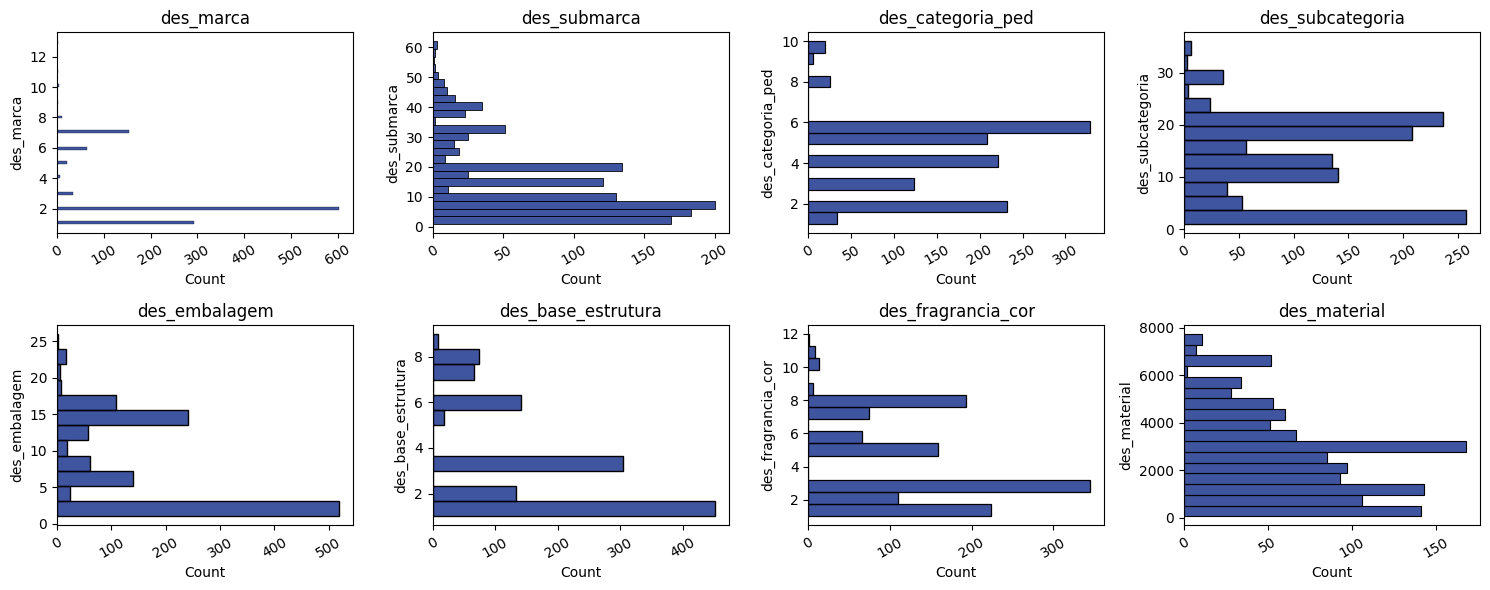

In [19]:
plot_matrix(
    columns_features=['des_marca', 'des_submarca', 'des_categoria_ped', 'des_subcategoria', 'des_embalagem', 'des_base_estrutura', 'des_fragrancia_cor', 'des_material'],
    data=dados_modelo,
    plot=sns.histplot,
    loop_feature='y',
    n_rows=2,
    n_cols=4,
    figsize=(15,6),
    label=False
)

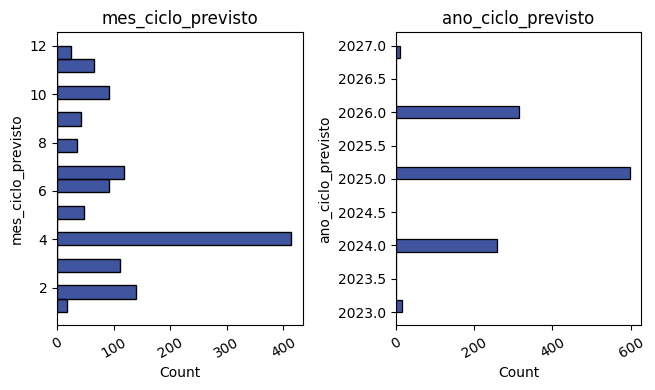

In [20]:
plot_matrix(
    columns_features=['mes_ciclo_previsto', 'ano_ciclo_previsto'],
    data=dados_modelo,
    plot=sns.histplot,
    loop_feature='y',
    n_rows=1,
    n_cols=3,
    figsize=(10,4),
    label=False
)

#### Análise Bivariada

Avaliando os atributos do produto frente à variável resposta
- As variáveis des_marca, des_material, ano_ciclo_previsto parecem ter uma maior correlação com a variável resposta

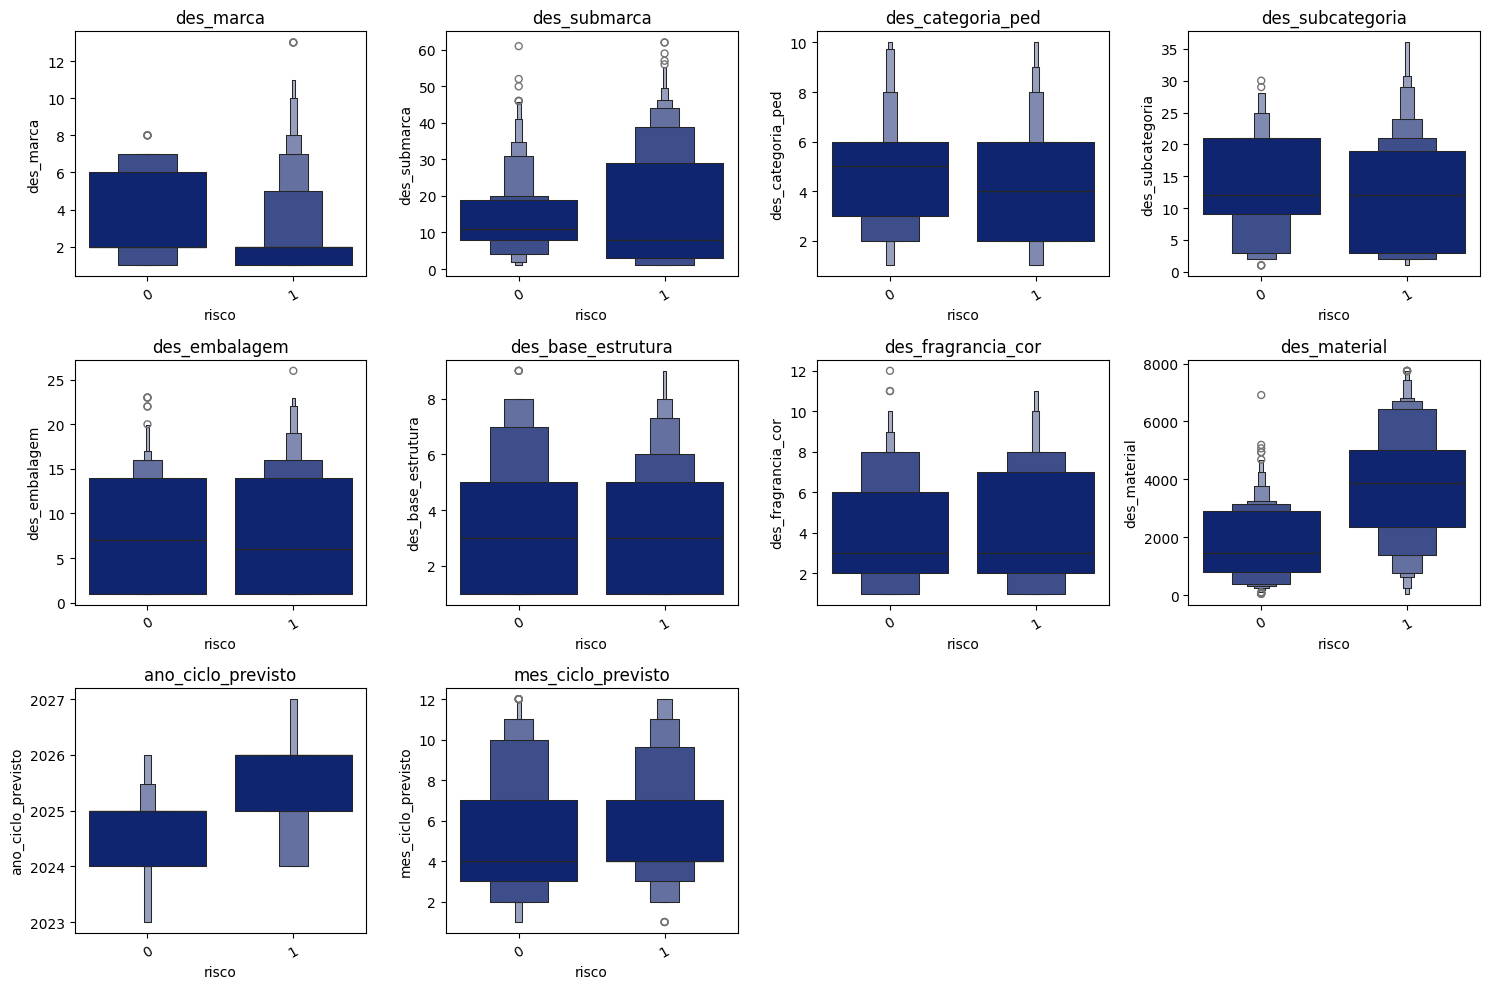

In [21]:
plot_matrix(
    columns_features=['des_marca', 'des_submarca', 'des_categoria_ped', 'des_subcategoria', 'des_embalagem', 'des_base_estrutura', 'des_fragrancia_cor', 'des_material', 'ano_ciclo_previsto', 'mes_ciclo_previsto'],
    data=dados_modelo,
    plot=sns.boxenplot,
    plot_kwargs={'x':TARGET},
    loop_feature='y',
    n_rows=3,
    n_cols=4,
    figsize=(15,10),
    label=False
)

#### Análise Multivariada

Gráfico salvo em: ../images/analise_multivariada.png


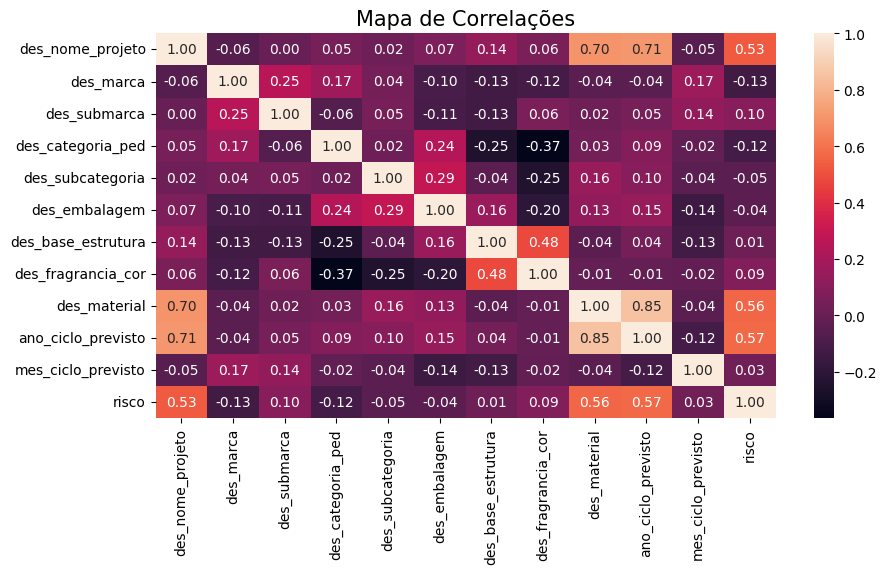

In [22]:
analise_multivariada(dados_modelo, dados_modelo.select_dtypes(include='int64').columns.tolist())

### **4. Modelagem**
Objetivo: Aplicar técnicas estatísticas ou de machine learning para gerar previsões ou classificações.

Atividades esperadas:
- Escolha de modelo (ex: regressão linear, árvore de decisão, etc).
- Definição de variáveis preditoras e variável-alvo.
- Ajuste de parâmetros e validação cruzada.
- Usar filtro des_ciclo_vida_projeto = ABERTO.

#### Escolha dos Modelos

In [23]:
## Modelos que serão avaliados
modelos = {
    'Regressão Logística': LogisticRegression(), ## Linear, bom para pequenos volumes de dados
    'KNN': KNeighborsClassifier(n_neighbors=10), ## Não linear, bom para problemas de média complexidade
    'Random Forest': RandomForestClassifier(),   ## Não linear, bom para problemas complexos (Bagging)
    'XGBoost': XGBClassifier()                   ## Não linear, bom para problemas complexos (Bootstrap)
}

#### Seleção de Atributos

##### Importancia das Features

- As variáveis serão selecionadas à partir do valor da sua importancia
- Serão consideradas apenas variáveis com importancia maior que 0.05


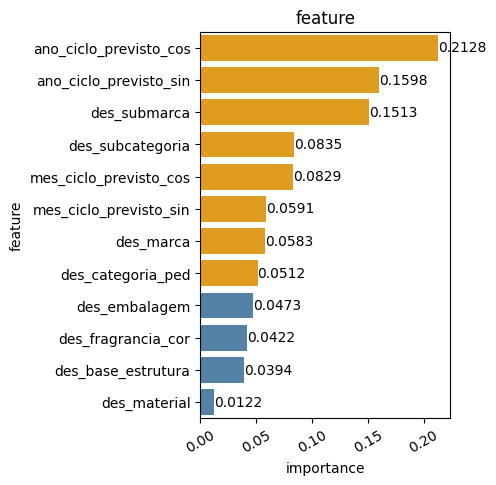

In [24]:
## As seguintes colunas devem ser desconsideradas do dataset para a seleção de features e modelagem
columns_to_drop = [

    # colunas referentes ao projeto
    'cod_projeto',
    'des_nome_projeto',
    'des_validade_projeto',

    # identificador do produto
    'cod_produto',

    # variáveis sem valor preditivo
    'des_ciclo_vida_projeto', # somente igual à ABERTO
    'des_validade_material',  # somente igual à ATIVO 

    # variáveis redundantes
    'vlr_temperatura', # redundantes em relação a variável resposta
    'des_temperatura', # redundantes em relação a variável resposta

    # variáveis do ciclycal encoding
    'ano_ciclo_previsto',
    'mes_ciclo_previsto',

    # variável resposta
    TARGET
]

features_importances = calcular_importancia_variaveis(RandomForestClassifier(), dados_modelo, dict_preparation, columns_to_drop, TARGET)
features_selected = seleciona_features(features_importances, 0.05)
colors = ['orange' if f in features_selected else 'steelblue' for f in features_importances.sort_values('importance', ascending=False).loc[:, 'feature'].tolist()]

plot_matrix(
    data=features_importances,
    columns_features=['feature'],
    plot=sns.barplot,
    loop_feature='y',
    sort_by='importance',
    n_rows=1,
    n_cols=1,
    figsize=(5, 5),
    plot_kwargs={'x':'importance', 'palette' :colors}
)

#### Validação Cruzada

Podemos avaliar os modelos através da validação cruzada

Entende-se que a métrica mais importante para o sucesso do modelo seja o Recall
- Como o objetivo é prever se um projeto sofrerá algum risco ou não, considera-se que é mais importante sermos capazes de identificar todos os riscos do que sermos precisos nas respostas

Posto isso, nota-se que a Random Forest apresentou melhor recall. Entretanto, como o XGBoost apresentou um recall muito próximo da Random Forest e se mostra superior na acurácia, precisão e F1-Score, optamos como seguir com este modelo 

In [25]:
# Parâmetros
n_splits = 5
k_folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# armazena métricas dos modelos
df_results = pd.DataFrame()

# para cada modelo
for nome_modelo in modelos.keys():
    
    # seleciona-se o modelo
    modelo = modelos[nome_modelo]

    # faz a validação cruzada
    df_aux = cross_validation(k_folds, modelo, nome_modelo, dados_modelo, dict_preparation, features_selected, TARGET)

    # armazena os resultados
    df_results = pd.concat([df_results, df_aux], axis=0)

df_results.round(3)


,Model Name,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.610,0.594,0.417,0.487
0,KNN,0.770,0.794,0.665,0.722
0,Random Forest,0.892,0.890,0.869,0.879
0,XGBoost,0.896,0.892,0.878,0.884


#### Ajuste de Hiperparâmetros

- O ajuste dos hiperparâmetros é realizados através do método Random Search, otimizando os principais parametros do modelo

In [26]:
# definicções
n_iter=50         # numero de iterações 
cv=5              # número de k_folds
scoring='recall'  # métrica a ser otimizada

# parametros a serem otimizados e seus valores
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),         # número de árvores
    'max_depth': np.arange(3, 16, 2),                  # profundidade das árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # shrinkage
    'subsample': [0.6, 0.8, 1.0],                      # amostragem das instâncias
    'colsample_bytree': [0.6, 0.8, 1.0],               # amostragem das features
    'gamma': [0, 1, 5],                                # ganho mínimo para split
    'min_child_weight': [1, 5, 10]                    # controle de underfitting
}

# definindo otimizados
random_search = RandomizedSearchCV(
    estimator=modelos['XGBoost'],
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=cv,
    verbose=0,
    random_state=0,
    scoring=scoring,
    n_jobs=-1,
)

# transformando dados
dados_modelo_transformed = preparacao_dos_dados(df=dados_modelo, dict_preparation=dict_preparation, is_train=True)

# Otimizando parametros
random_search.fit(dados_modelo_transformed[features_selected], dados_modelo_transformed[TARGET])

# armazenando melhores parametros
best_params = random_search.best_params_
save_picked_file(file=best_params, name='../models/best_params')

['../models/best_params.pkl']

### **5. Avaliação**
Objetivo: Validar os resultados dos modelos e avaliar se atendem ao objetivo de negócio.

Atividades esperadas:
- Métricas de desempenho (MAPE, RMSE, R² etc.).
- Comparação com benchmarks históricos.
- Validação qualitativa com base no contexto de negócio.
- Usar filtro des_ciclo_vida_projeto = ABERTO.


#### Performance com os dados de teste

Com o modelo e os hiperparametros definidos, agora o modelo foi avaliados com dados não visto
- Nota-se uma performance levemente inferior à performance dos os dados de validação (como esperado) mas ainda assim dentro das expectativas do projeto

In [27]:
# preparando dados de treino e teste
dados_treino_transformed = preparacao_dos_dados(df=dados_modelo, dict_preparation=dict_preparation, is_train = True, final=True)
dados_teste_transformed = preparacao_dos_dados(df=dados_teste, dict_preparation=dict_preparation, is_train = False, final=True)

# definindo modelo
modelo = XGBClassifier(**best_params)

# ajustando modelo
modelo.fit(dados_treino_transformed[features_selected], dados_treino_transformed[TARGET])

# salvando melhor modelo
save_picked_file(file=modelo, name='../models/best_model')

# fazendo predicao
y_hat = modelo.predict(dados_teste_transformed[features_selected])

# calculando métricas
df_results_final = classification_metrics(model_name='XGBoost', y_pred=y_hat, y_true=dados_teste_transformed[TARGET])

In [28]:
resultados_teste = df_results_final.round(3)
resultados_teste['Dataset'] = 'Teste'

resultados_validacao = df_results.loc[df_results['Model Name'] == 'XGBoost'].round(3)
resultados_validacao['Dataset'] = 'Validação'

pd.concat([resultados_validacao, resultados_teste], axis=0)

,Model Name,Accuracy,Precision,Recall,F1-Score,Dataset
0,XGBoost,0.896,0.892,0.878,0.884,Validação
0,XGBoost,0.890,0.873,0.880,0.876,Teste


### **6. Implementação do Modelo**
Objetivo: Preparar a entrega do modelo/solução e demonstrar como ele pode ser utilizado.

Atividades esperadas:
- Entrega de dashboard, código ou relatório explicativo.
- Sugestão de como integrar o modelo no processo de decisão da empresa.
- Proposta de melhorias contínuas (ex: atualização mensal do modelo).
- Usar filtro des_ciclo_vida_projeto = NÃO INICIADO e PRÉ-CONTROLE.


##### Preparação dos Dados de Produção

Fazendo tratamentos nos dados de produção para a aplicação no modelo

In [29]:
## removendo nulos
dados_producao = dados_producao.dropna(subset=['ano_ciclo_previsto'])

## padronizando coluna de data
dados_producao = padronizar_coluna_data(dados_producao, 'ano_ciclo_previsto')

## criando colunas de semana e mês de lançamento
dados_producao['mes_ciclo_previsto'] = dados_producao['ano_ciclo_previsto'].dt.strftime('%m').astype('Int64')
dados_producao['ano_ciclo_previsto'] = dados_producao['ano_ciclo_previsto'].dt.strftime('%Y').astype('Int64')

##### Predição para projetos Não Iniciados e em Pré Cadastro

In [30]:
## preparando dados
dados_producao_transformed = preparacao_dos_dados(dados_producao, dict_preparation, False)

## selecionando features
X_prod = dados_producao_transformed[features_selected]

## fazendo predição
modelo = load_picked_file(name='../models/best_model')
y_hat = modelo.predict(X_prod)
dados_producao['risco_previsto'] = y_hat
dados_producao['risco_previsto'] = dados_producao['risco_previsto'].apply(lambda x: 'SIM' if x == 1 else 'NAO')
dados_producao['risco_previsto_projeto'] = dados_producao.groupby('cod_projeto')['risco_previsto'].transform('max')
dados_producao.reset_index(drop=True)


,cod_projeto,des_nome_projeto,des_validade_projeto,des_marca,des_submarca,des_categoria_ped,des_subcategoria,des_embalagem,des_base_estrutura,des_fragrancia_cor,des_ciclo_vida_projeto,cod_produto,des_material,des_validade_material,ano_ciclo_previsto,vlr_temperatura,des_temperatura,mes_ciclo_previsto,risco_previsto,risco_previsto_projeto
0,432261d7,457,ATIVO,7,20,6,1,9,9,11,NÃO INICIADO,22a25b24,7430,ATIVO,2027,None,0. DESCONHECIDO,5,SIM,SIM
1,dbdbf13e,623,ATIVO,2,34,1,1,2,9,11,NÃO INICIADO,522746ff,8152,ATIVO,2027,None,0. DESCONHECIDO,4,SIM,SIM
2,5e89bbb7,249,ATIVO,1,1,6,2,1,1,3,NÃO INICIADO,76590def,2565,ATIVO,2025,None,0. DESCONHECIDO,3,SIM,SIM
3,d8b50a5d,568,ATIVO,2,6,4,2,1,1,10,NÃO INICIADO,f982bac9,7400,ATIVO,2027,None,0. DESCONHECIDO,4,SIM,SIM
4,9024cf33,582,ATIVO,1,1,4,2,1,1,3,NÃO INICIADO,d07c830a,7686,ATIVO,2027,None,0. DESCONHECIDO,7,SIM,SIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,cd5c1489,579,ATIVO,4,12,2,30,9,3,8,PRÉ CONTROLE,77a2ca74,7604,ATIVO,2027,None,0. DESCONHECIDO,8,SIM,SIM
557,35180c89,555,ATIVO,1,55,2,34,18,2,2,PRÉ CONTROLE,0d9864da,7274,ATIVO,2027,None,0. DESCONHECIDO,3,SIM,SIM
558,61e58ca3,616,ATIVO,2,71,2,34,18,2,2,NÃO INICIADO,d25bb8b4,8052,ATIVO,2027,None,0. DESCONHECIDO,4,SIM,SIM
559,fe26348b,554,ATIVO,2,4,2,35,1,3,3,PRÉ CONTROLE,8cfba3e8,7258,ATIVO,2027,None,0. DESCONHECIDO,2,SIM,SIM


In [31]:
create_table_bigquery(data=dados_modelo, projeto=PROJETO, dataset='dados', table_name='bd_projetos_abertos')
create_table_bigquery(data=dados_producao, projeto=PROJETO, dataset='dados', table_name='bd_projetos_nao_iniciados')

'Done!'